### Imports e bibliotecas


In [2]:
# Instalação do PySpark e Spark-nlp
!pip install pyspark
!pip install spark-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=94d7e8e5d276bfce6b3b6b289759512facc271b3de2ba439f79473994805c3ab
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 kB 9.6 MB/s eta 0:00:00


In [3]:
### Imports Necessários

## Imports do Python
from collections import Counter
import nltk
import pandas as pd
import os
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import string
import re
import regex
import unicodedata

## Imports do Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score,cohen_kappa_score,roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression

## Imports do PySpark
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.clustering import LDA

## Imports do spark-nlp
import sparknlp
from sparknlp.annotator import Chunker, PerceptronModel, LemmatizerModel, Stemmer, Tokenizer, StopWordsCleaner, Normalizer, YakeKeywordExtraction, SentenceDetector, NGramGenerator, BertEmbeddings
from sparknlp.annotator import NerDLModel, BertForTokenClassification, NerConverter, SentenceDetectorDLModel
from sparknlp.annotator import (Tokenizer, Normalizer, LemmatizerModel, StopWordsCleaner)
from sparknlp.base import DocumentAssembler, Finisher, LightPipeline
from sparknlp.pretrained import PretrainedPipeline


## Imports do nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Ignora os avisos de depreciação
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pre processamento

In [ ]:
# Ler a base
data1 = pd.read_csv("/content/drive/MyDrive/dataset/df_afavor.csv")
data2 = pd.read_csv("/content/drive/MyDrive/dataset/df_neutro.csv")
data3 = pd.read_csv("/content/drive/MyDrive/dataset/df_contra.csv")
data = pd.concat([data1, data2, data3])

In [5]:
# casa
data1 = pd.read_csv("/content/drive/MyDrive/dataset_tcc/df_afavor.csv")
data2 = pd.read_csv("/content/drive/MyDrive/dataset_tcc/df_neutro.csv")
data3 = pd.read_csv("/content/drive/MyDrive/dataset_tcc/df_contra.csv")
data = pd.concat([data1, data2, data3])

In [ ]:
data.shape

(177385, 2)

In [6]:
columns_to_drop = ['rotulos_preditos','user','entities','seguidores','id']
data = data.drop(columns=columns_to_drop)


In [ ]:
data.head()

,text,clean_text
0,@STF_oficial O delinquente infenso ao estado d...,delinquente infenso estado democratico direito...
1,Chega aqui @AndreJanonesAdv @STF_oficial @Flav...,chega aqui olha bonitinho
2,@GayerGus Com todo o respeito que tenho por vo...,todo respeito nao vejo outra saida pais aonde ...
3,@simonetebetbr A culpa é do congresso!!! Vcs s...,culpa congresso vcs culpados
4,@JovemPanNews Se o povo é que construiu o povo...,povo construiu povo pode destruir congresso povo


In [ ]:
data.dtypes

text          object
clean_text    object
dtype: object

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177385 entries, 0 to 76247
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        177385 non-null  object
 1   clean_text  177385 non-null  object
dtypes: object(2)
memory usage: 4.1+ MB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        10000 non-null  object
 1   clean_text  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [23]:
df = data

# seleção de 3000 tweets aleatórios
df_aleatorio = df.sample(n=100000, random_state=24)

# salvando em um novo arquivo XLSX
df_aleatorio.to_excel('tweets_aleatorios.xlsx', index=False)
df_aleatorio.to_csv('tweets_aleatorios.csv', index=False)


* Foi salvo em xlsx pois em csv estava havendo problema na leitura do arquivo por causa dos delimitadores, com o tempo curto foi a solução adotada.

In [8]:
data.to_excel("tweets_trabalho.xlsx", index=False)

# Spark

In [9]:
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer
from sparknlp.annotator import BertForSequenceClassification
from pyspark.ml import Pipeline

# Instanciando o Spark com spark-nlp

spark = sparknlp.start()

In [24]:
# Ler os arquivos CSV
dataset = (spark.read.option("header",True) \
                    .option("delimiter",",") \
                    .option("multiLine", "true") \
          .csv("/content/tweets_aleatorios.csv"))

In [ ]:
# Visualizando o schema dos dados
dataset.printSchema()

root
 |-- text: string (nullable = true)
 |-- clean_text: string (nullable = true)



In [ ]:
# Visualizando os dados
dataset.show(11, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                                                               |clean_text                                                                                                                                                                                        |
+---------------------

In [11]:
# Criando as etapas da pipeline
documentAssembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

seq_classifier = BertForSequenceClassification.pretrained("bert_classifier_dehatebert_mono_portugese","pt") \
    .setInputCols(["document", "token"]) \
    .setOutputCol("class")

# Criando a pipeline
pipeline = Pipeline(stages=[documentAssembler, tokenizer, seq_classifier])

bert_classifier_dehatebert_mono_portugese download started this may take some time.
Approximate size to download 599.3 MB
[OK!]


In [25]:
# Treinando e transformando o dataset
model = pipeline.fit(dataset)
result = model.transform(dataset)

In [26]:
# Converta o resultado Spark DataFrame para pandas DataFrame
result_pd = result.select("text","clean_text","class.result").toPandas()

In [ ]:
# result_pd['result'] = result_pd['result'].apply(lambda x: x[0].strip() if isinstance(x, list) else x.strip())

In [31]:
result_pd['result'] = result_pd['result'].apply(lambda x: x[0].strip() if isinstance(x, list) and len(x) > 0 else '' if isinstance(x, list) else x.strip())

In [29]:
result_pd.shape

(101899, 3)

In [32]:
result_pd.head(20)

,text,clean_text,result
0,literalmente os imundos fazendo uma arruaça de...,literalmente imundos fazendo arruaca dentro pl...,NON_HATE
1,mas que segurança de quinta categoria tem ness...,seguranca quinta categoria nesse congresso,NON_HATE
2,"""@bernardokuster2 É golpe em cima de golpe; o ...",golpe cima golpe povo brasilia `` bi '',NON_HATE
3,@77_frota @STF_oficial @alexandre @FlavioDino ...,alem patriotario terrorista,HATE
4,Temo que esse pessoal fique mais tempo no cong...,temo pessoal fique tempo congresso pq policia ...,NON_HATE
5,Mete a porrada nesses terroristas em Brasília ...,mete porrada ness terroristas brasilia profess...,HATE
6,Brasília tem que ser resolvido na força mesmo ...,brasilia resolvido forca policia agir assim,NON_HATE
7,@deltanmd Tudo isso começou quando o @STF_ofic...,tudo comecou mandar soltar ladrao bandido cond...,HATE
8,Em 2013 tambem tentaram entrar no Palacio dos ...,2013 tambem tentaram entrar palacio bandeirant...,HATE
9,pelo oq eu entendi a polícia de brasilia não t...,oq entendi policia brasilia bala borracha vist...,NON_HATE


In [33]:
result_pd.to_csv("tweets_odio.csv")
result_pd.to_excel("tweets_odio.xlsx", index=False)

In [34]:
base_odio = result_pd[result_pd['result'] == 'HATE']
base_nao_odio = result_pd[result_pd['result'] == 'NON_HATE']

In [35]:
base_odio.to_csv("base_odio.csv")
base_nao_odio.to_csv("base_nao_odio.csv")

# Análise dos dados




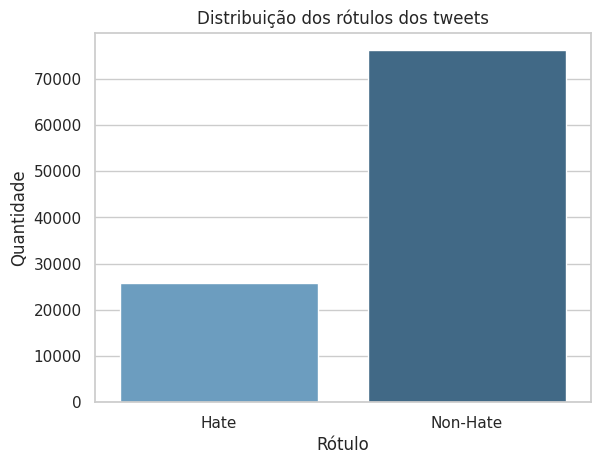

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criar DataFrame com a quantidade de tweets por rótulo
df_counts = pd.DataFrame({
    'Rótulo': ['Hate', 'Non-Hate'],
    'Quantidade': [base_odio.shape[0], base_nao_odio.shape[0]]
})

# Criar o gráfico de barras
sns.set(style="whitegrid")
sns.barplot(x='Rótulo', y='Quantidade', data=df_counts, palette="Blues_d")

# Adicionar título
plt.title('Distribuição dos rótulos dos tweets')

# Mostrar o gráfico
plt.show()


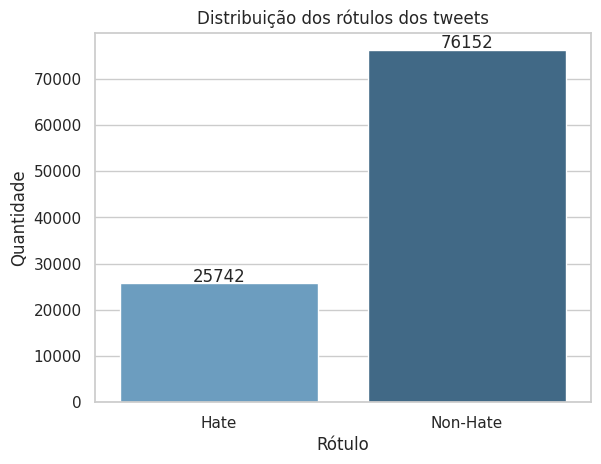

In [37]:
import seaborn as sns
# Criar o gráfico de barras
sns.set(style="whitegrid")
ax = sns.barplot(x='Rótulo', y='Quantidade', data=df_counts, palette="Blues_d")

# Adicionar rótulos aos valores das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Adicionar título
plt.title('Distribuição dos rótulos dos tweets')

# Mostrar o gráfico
plt.show()


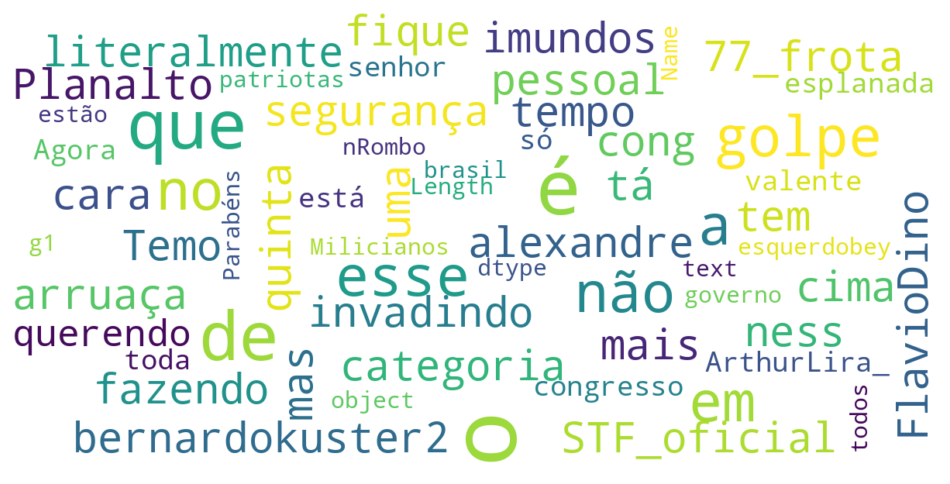

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

stopwords = set()
# adicionando palavras-chave e palavras indesejadas como stopwords
#stopwords.update([])


wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=200,
    max_font_size=40,
    scale=3,
    random_state=2
).generate(str(result_pd['text']))

# Wordcloud sem tratamento
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

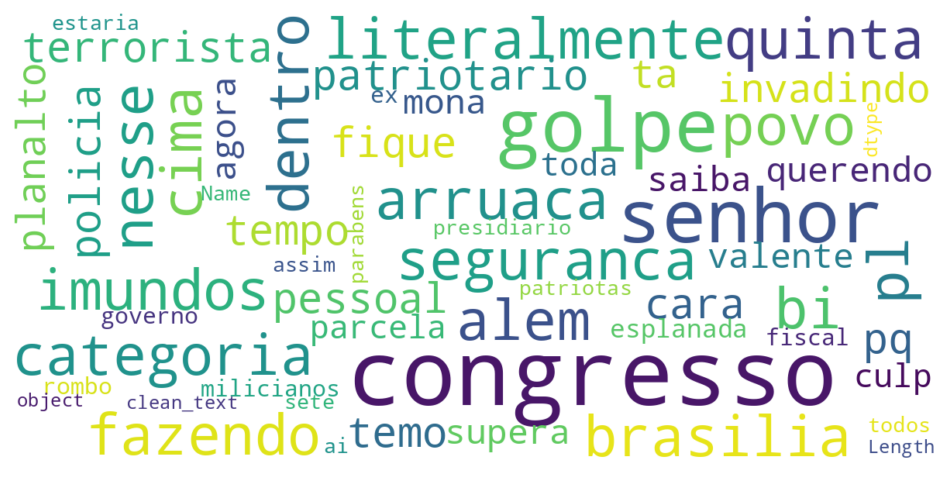

In [39]:
stopwords = set()
# adicionando palavras-chave e palavras indesejadas como stopwords
#stopwords.update([])


wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=200,
    max_font_size=40,
    scale=3,
    random_state=2
).generate(str(result_pd['clean_text']))

# Wordcloud sem tratamento
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

* Ódio

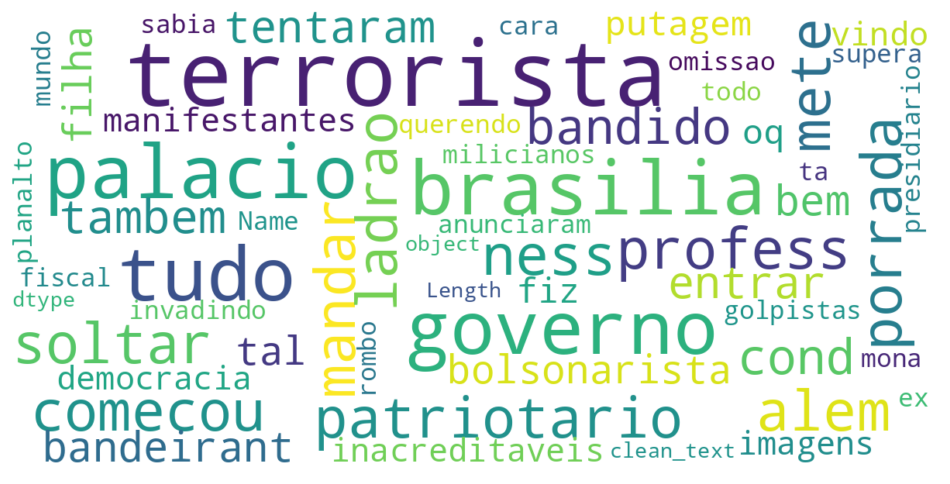

In [40]:
stopwords = set()
# adicionando palavras-chave e palavras indesejadas como stopwords
#stopwords.update([])


wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=200,
    max_font_size=40,
    scale=3,
    random_state=2
).generate(str(base_odio['clean_text']))

# Wordcloud sem tratamento
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

* Não ódio

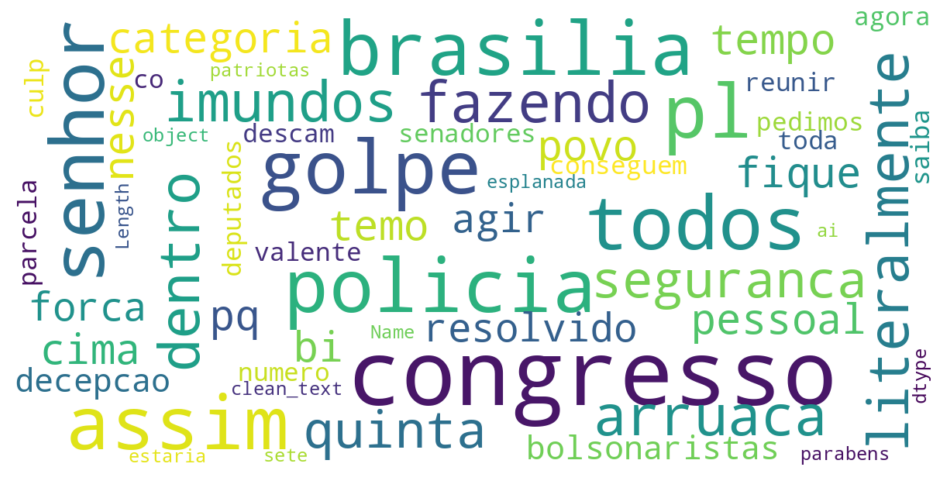

In [41]:
stopwords = set()
# adicionando palavras-chave e palavras indesejadas como stopwords
#stopwords.update([])


wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=200,
    max_font_size=40,
    scale=3,
    random_state=2
).generate(str(base_nao_odio['clean_text']))

# Wordcloud sem tratamento
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

* Palavras frequentes

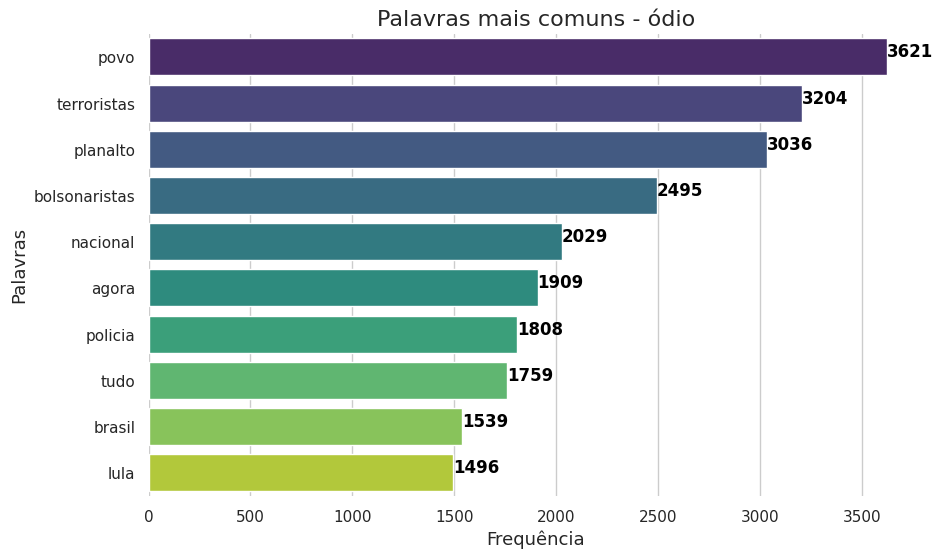

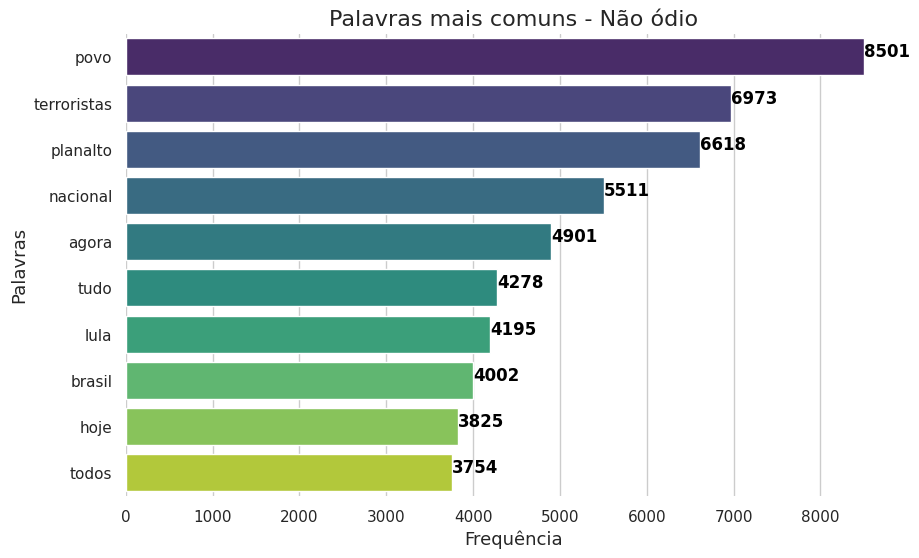

In [47]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de palavras para remover
words_to_remove = ['q','brasilia','congresso','stf','ta','pra','...','la','vai']

# Função para calcular a frequência das palavras
def get_word_frequency(df, column_name):
    # Concatena todas as palavras em uma única lista
    words = [word for text in df[column_name] if pd.notnull(text) for word in text.split()]

    # Remove as palavras indesejadas
    words = [word for word in words if word not in words_to_remove]

    # Cria um objeto Counter para obter a contagem de cada palavra
    word_frequency = Counter(words)

    return word_frequency


# Função para plotar as palavras mais comuns
def plot_most_common_words(word_frequency, title):
    # Obtém as 10 palavras mais comuns
    words, counts = zip(*word_frequency.most_common(10))

    # Converte para listas para que possamos manipular mais facilmente
    words = list(words)
    counts = list(counts)

    # Cria uma nova figura
    plt.figure(figsize=(10, 6))

    # Cria um gráfico de barras horizontais com Seaborn
    sns.barplot(x=counts, y=words, palette="viridis")

    # Adiciona rótulos de dados em cada barra
    for i, v in enumerate(counts):
        plt.text(v, i, str(v), color='black', fontweight='bold')

    # Adiciona título e rótulos
    plt.title(title, fontsize=16)
    plt.xlabel('Frequência', fontsize=13)
    plt.ylabel('Palavras', fontsize=13)

    # Remove as bordas do gráfico
    sns.despine(left=True, bottom=True)

    # Mostra o gráfico
    plt.show()

# Obtém a frequência de palavras para cada dataframe
word_frequency_odio = get_word_frequency(base_odio, 'clean_text')
word_frequency_nodio = get_word_frequency(base_nao_odio, 'clean_text')

# Plota as 10 palavras mais comuns para cada categoria
plot_most_common_words(word_frequency_odio, 'Palavras mais comuns - ódio')
plot_most_common_words(word_frequency_nodio, 'Palavras mais comuns - Não ódio')



* Hashtags

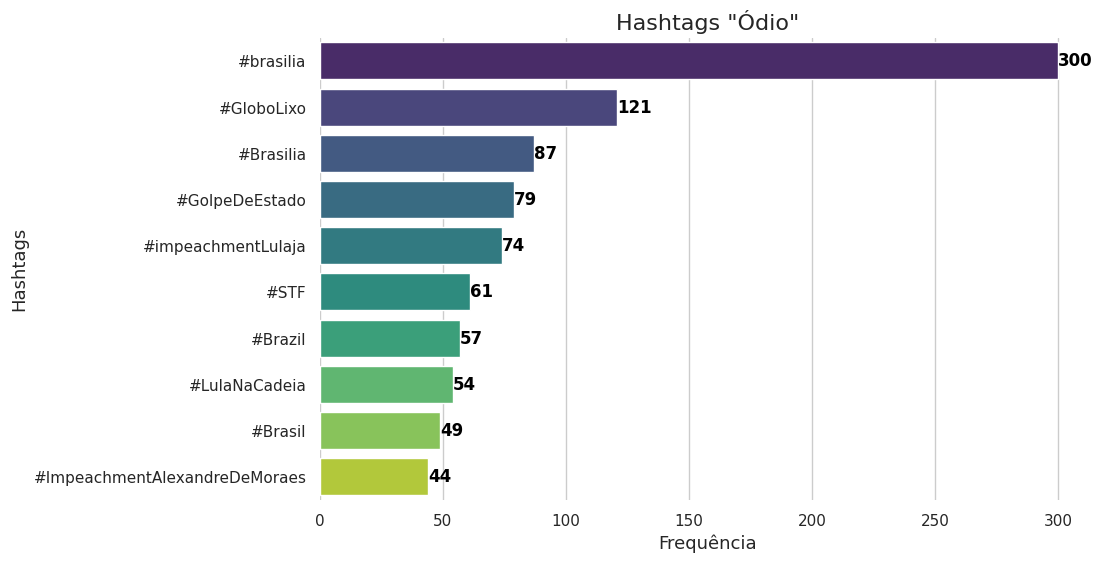

In [48]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def extract_hashtags(text):
    # Utiliza expressão regular para encontrar as hashtags no texto
    hashtags = re.findall(r'\#\w+', text)
    return hashtags

def get_hashtag_frequency(df):
    # Inicializa um contador vazio para armazenar a frequência das hashtags
    hashtag_counter = Counter()

    # Percorre cada linha do DataFrame
    for index, row in df.iterrows():
        # Extrai as hashtags do texto da linha
        hashtags = extract_hashtags(row['text'])

        # Atualiza o contador com as hashtags da linha
        hashtag_counter.update(hashtags)

    # Retorna o contador com a frequência das hashtags
    return hashtag_counter


def plot_hashtag_frequency(hashtag_freq, title):
    # Converte o contador em um DataFrame
    df_hashtags = pd.DataFrame.from_dict(hashtag_freq, orient='index', columns=['Frequência'])

    # Ordena o DataFrame pela frequência em ordem decrescente
    df_hashtags = df_hashtags.sort_values(by='Frequência', ascending=False)

    # Limita o número de hashtags a serem exibidas
    df_hashtags = df_hashtags.head(10)

    # Cria uma nova figura
    plt.figure(figsize=(10, 6))

    # Cria um gráfico de barras horizontais com Seaborn
    sns.barplot(x='Frequência', y=df_hashtags.index, data=df_hashtags, palette="viridis")

    # Adiciona rótulos de dados em cada barra
    for i, v in enumerate(df_hashtags['Frequência']):
        plt.text(v, i, str(v), color='black', fontweight='bold', va='center')

    # Adiciona título e rótulos
    plt.title(title, fontsize=16)
    plt.xlabel('Frequência', fontsize=13)
    plt.ylabel('Hashtags', fontsize=13)

    # Remove as bordas do gráfico
    sns.despine(left=True, bottom=True)

    # Mostra o gráfico
    plt.show()



# Obtém a frequência das hashtags para a coluna "text" do DataFrame
hashtag_freq = get_hashtag_frequency(base_odio)

# Plota a frequência das hashtags para o DataFrame de exemplo
plot_hashtag_frequency(hashtag_freq, 'Hashtags "Ódio"')


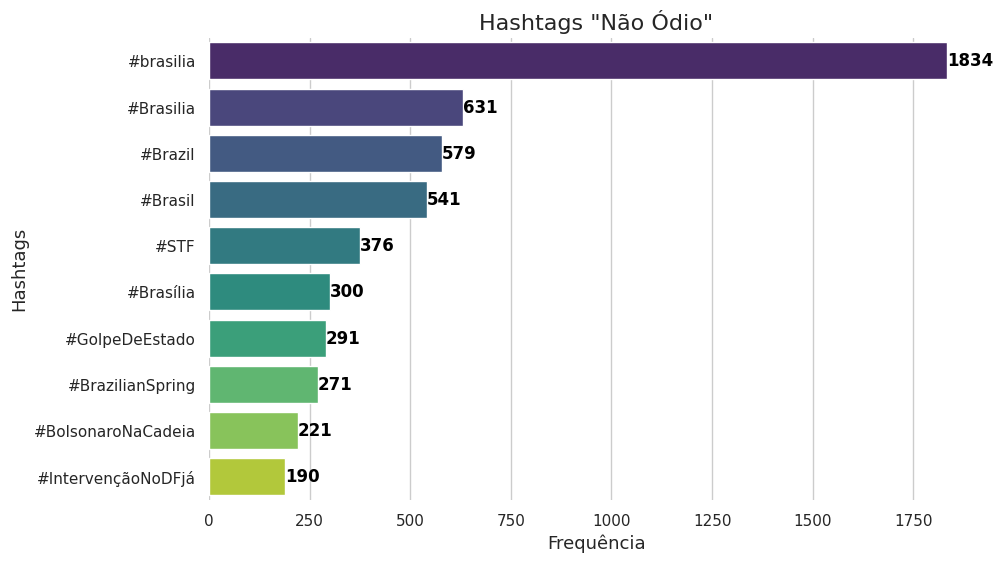

In [49]:
# Obtém a frequência das hashtags para o DataFrame de exemplo
hashtag_freq = get_hashtag_frequency(base_nao_odio)

# Plota a frequência das hashtags para o DataFrame de exemplo
plot_hashtag_frequency(hashtag_freq, 'Hashtags "Não Ódio"')


# Aux

In [ ]:
nltk.download('punkt',quiet = True)
nltk.download('stopwords',quiet = True)
nltk.download('averaged_perceptron_tagger',quiet = True)
nltk.download('wordnet',quiet = True)


def clean_text(texto):

    def remove_tweet_ruido(tweets_text):

          clean_text = re.sub(r'^rt\s+', '', tweets_text)
          clean_text = re.sub(r'@\S+', '', clean_text)
          clean_text = re.sub(r'http\S+', '', clean_text)
          clean_text = clean_text.replace("\n", " ")

          return clean_text

    # Transforme as letras para minúscula
    texto = texto.lower()

    # Remova o ruido do texto
    texto = remove_tweet_ruido(texto)

    # Tokenize o texto em palavras
    palavras = word_tokenize(texto)

    # Remova pontuações
    palavras_sem_pontuacao = [palavra for palavra in palavras if palavra not in string.punctuation]

    # Remova stopwords
    stops = set(stopwords.words('portuguese'))
    palavras_sem_stopwords = [palavra for palavra in palavras_sem_pontuacao if palavra not in stops]

    # Lematize o texto
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(palavra, pos='v') if pos.startswith('V') else lemmatizer.lemmatize(palavra) for palavra, pos in nltk.pos_tag(palavras_sem_stopwords)]

    # Junte as palavras limpas
    texto_limpo = ' '.join(lemmas)

    # Remova acentos
    texto_limpo = unicodedata.normalize('NFKD', texto_limpo).encode('ASCII', 'ignore').decode('ASCII')

    return texto_limpo


In [ ]:
### Base completa ###

# Aplica o processamento de texto na coluna text e cria uma nova "clean_text"
data['clean_text'] = data['text'].apply(clean_text)

# Remove tweets com menos de 2 palavras e tweets que ficaram vazios
data['num_palavras'] = data['clean_text'].apply(lambda x: len(x.split()))
data = data.loc[data['num_palavras'] > 1]
data = data.dropna(axis=1, how='all')


print(f"A base de dados 'data' possui {data.shape[0]} linhas e {data.shape[1]} colunas.")

A base de dados 'data' possui 177385 linhas e 8 colunas.
